# Imitation Learning

Imitation learning is a paradigm where an agent learns to mimic an **expert's behavior** instead of learning purely from trial-and-error rewards (e.g., reinforcement learning). 

The simplest common approach is called "**behavior cloning**" (BC). It treats the expert's demonstrations as training data samples; train a policy using the expert's input(state) and output(action) pairs via supervised learning. However, BC often fails because the policy is only trained on states the expert visited, so if it ever drifts off that trajectory, it encounters states that the policy doesn't know what to do.

**[DAgger (Dataset Aggregation)](https://arxiv.org/pdf/1011.0686)** is an interactive imitation learning algorithm that deals with the issue above. The key idea is to keep utilizing the expert's knowledge during training and gradually expand the training data to include those "off-course" states. Instead of training the policy by cloning the expert's behavior, DAgger iteratively refines the policy:

1. After initial training on expert data (behavior cloning), execute the policy in the environment. (Policy rollout) 
2. Store all the states the policy visits (it may include "bad" states).
3. Query the expert for the correct action in each of those states. (Expert labeling)
4. Aggregate these new state-action pairs into the training dataset.
5. Update the policy on this expanded dataset (so it knows what to do in new states).
6. Repeat this process.

Although DAgger requires querying the expert online, it improves behavior cloning by training on a dataset that better resembles the observations the trained policy is likely to encounter. [(Reference)](https://imitation.readthedocs.io/en/latest/algorithms/dagger.html#:~:text=DAgger%20,requires%20querying%20the%20expert%20online)

In [1]:
# The following lines are needed when using Windows 
# An error regarding this happens when the program is trying to initialize multiple versions of the libiomp5md.dll library (the Intel OpenMP runtime), which leads to conflicts. 
import os
os.environ["KMP_DUPLICATE_LIB_OK"] = "TRUE"

import sys

sys.path.append("C:\\Users\\sc3377\\Documents\\balloon-outreach")

In [2]:
import xarray as xr
import numpy as np
import datetime as dt
import matplotlib.pyplot as plt
from pathlib import Path
import importlib.resources as pkg_resources
import time

from env.balloon_env import BalloonERAEnvironment
from agent.mppi_agent import MPPIAgentWithCostFunction, MPPIAgent
# from env.visualize import plot_wind_field, plot_trajectory_earth

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader

## Setup Environment

In [3]:
import xarray as xr

ds          = xr.open_dataset("C:\\Users\\sc3377\\Documents\\balloon-outreach\\era5_data.nc", engine="netcdf4")
start_time  = dt.datetime(year=2024, month=7, day=1, hour=0, minute=0)

#This is Ithaca
initial_lat = 42.6
initial_lon = -76.5
initial_alt = 10.0
target_lat = 47
target_lon = -78
target_alt = 12.0
time_step = 120 #120 seconds
max_steps = int(1440/(time_step/60)) #1 day
noise_std = 0.1
horizon=10
num_samples=10
num_iterations=1
env = BalloonERAEnvironment(ds=ds, 
                            start_time=start_time, 
                            initial_lat=initial_lat, 
                            initial_lon=initial_lon, 
                            initial_alt=initial_alt, 
                            target_lat=target_lat, 
                            target_lon=target_lon,
                            target_alt=target_alt, 
                            dt=time_step,
                            viz=False)
# env.wind_field.disable_noise()
# env.wind_field.enable_noise(noise_seed=1)

In [4]:
env.wind_field.disable_noise()
initial_state = env.reset()
print(initial_state) # 21-dimensional vector

# state = (latitude, longitude, altitude, volume/max_volume, sand/max_sand, 
# vertical velocity, current_time, uv vectors in 7 different pressure levels)

[ 42.6        -76.5         10.           1.           1.
   0.           0.           2.68826294  -2.50693054  11.1584198
  -7.97099304  14.01635132  -5.00876465  27.14085999   3.41699524
  34.82033386  14.09255371  38.58664856   7.6340332   18.78843994
  -4.25058899]


## Define our policy network

In [5]:
class PolicyNet(nn.Module):
    def __init__(self, input_dim=21, hidden_dim=64, output_dim=1):
        super(PolicyNet, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim*2)
        self.ln1 = nn.LayerNorm(hidden_dim*2)
        self.fc2 = nn.Linear(hidden_dim*2, hidden_dim)
        self.ln2 = nn.LayerNorm(hidden_dim)
        self.fc3 = nn.Linear(hidden_dim, output_dim)

        # Weight initialization
        nn.init.kaiming_uniform_(self.fc1.weight, nonlinearity='relu')
        nn.init.zeros_(self.fc1.bias)
        nn.init.kaiming_uniform_(self.fc2.weight, nonlinearity='relu')
        nn.init.zeros_(self.fc2.bias)
        nn.init.xavier_uniform_(self.fc3.weight, gain=nn.init.calculate_gain('tanh'))
        nn.init.zeros_(self.fc3.bias)

    def forward(self, x):
        # x shape: (batch_size, input_dim)
        x = self.fc1(x)
        x = self.ln1(x)
        x = F.relu(x)
        x = self.fc2(x)
        x = self.ln2(x)
        x = F.relu(x)
        x = self.fc3(x)
        return F.tanh(x)

# Initialize policy network and optimizer
policy = PolicyNet()
optimizer = optim.Adam(policy.parameters(), lr=1e-3)
loss_fn = nn.MSELoss()

### Plot a trajectory of randomly initialized policy network

In [6]:
# Evaluate a policy on the environment
def evaluate_policy(env: BalloonERAEnvironment, 
                    policy: nn.Module,
                    max_steps: int,
                    policy_name: str):
    policy.eval()
    if policy.training:
        print("→ policy is in training mode")
    else:
        print("→ policy is in evaluation mode")

    state = env.reset()
    total_reward = 0.0

    # Store trajectory for plotting
    trajectory = [(state[0], state[1])]  # (lat, lon) pairs
    altitudes = [state[2]]  # Store altitudes

    actions = []
    velocities = []
    helium_mass = []
    sands = []

    for step in range(max_steps):
        state_tensor = torch.from_numpy(state).float().unsqueeze(0)      # shape (1, 21)
        action_pred = policy(state_tensor).item()                        # continuous action
        state, reward, done, info = env.step(action_pred)
        total_reward += reward

        actions.append(float(action_pred) if isinstance(action_pred, np.ndarray) else float(action_pred))
        velocities.append(env.balloon.vertical_velocity)
        helium_mass.append(env.balloon.helium_mass)
        sands.append(env.balloon.sand)

        # Store position and altitude
        trajectory.append((state[0], state[1]))
        altitudes.append(state[2])

        if done:
            print(f"\nEpisode terminated: {info}")
            break
    print(f"Total reward obtained from current policy: {total_reward:.2f}")

    # Plot final trajectory
    plt.figure(figsize=(12, 5))
    
    # Position plot
    plt.subplot(1, 2, 1)
    lats, lons = zip(*trajectory)
    plt.plot(lons, lats, 'b-', alpha=0.5)
    plt.plot(lons[0], lats[0], 'go', label='Start')
    plt.plot(lons[-1], lats[-1], 'ro', label='End')
    # if agent.objective == 'target':
    plt.plot(env.target_lon, env.target_lat, 'rx', label='Target End')
    plt.grid(True)
    plt.title(f'Balloon Trajectory in {max_steps} max steps')
    plt.xlabel('Longitude')
    plt.ylabel('Latitude')
    plt.legend()
    
    # Altitude plot
    plt.subplot(1, 2, 2)
    plt.plot(altitudes, 'b-')
    # if agent.objective == 'target':
    plt.axhline(y=env.target_alt,linewidth=1, color='r', label='Target End Altitude')
    plt.grid(True)
    plt.title(f'Altitude Profile using {env.dt} delta_time')
    plt.xlabel('Time Step')
    plt.ylabel('Altitude (km)')
    plt.legend()
    
    plt.tight_layout()
    plt.savefig(f'balloon_trajectory_and_altitude_{policy_name}.png')
    plt.close()

    # 추가: Target velocity (action) vs. Current velocity, Resource 변화
    plt.figure(figsize=(12, 4))

    # (1) Target velocity (action) vs. Current velocity
    plt.subplot(1, 2, 1)
    plt.plot(actions, label='Target velocity (action)')
    plt.plot(velocities, label='Current vertical velocity')
    plt.xlabel('Step')
    plt.ylabel('Velocity (m/s)')
    plt.title('Target vs. Current Vertical Velocity')
    plt.legend()
    plt.grid(True)

    # (2) Resource 변화 (volume, sand)
    plt.subplot(1, 2, 2)
    plt.plot(helium_mass, label='Helium Mass')
    plt.plot(sands, label='Sand')
    plt.xlabel('Step')
    plt.ylabel('Resource')
    plt.title('Resource Change')
    plt.legend()
    plt.grid(True)

    plt.tight_layout()
    plt.savefig(f'balloon_velocity_and_resource_test_{policy_name}.png')
    plt.close()

    return total_reward

In [7]:
env.wind_field.disable_noise()
evaluate_policy(env, policy, max_steps=max_steps, policy_name='random_policy_noiseless_wf')

→ policy is in evaluation mode

Episode terminated: Time limit reached
Total reward obtained from current policy: -1174.95


np.float64(-1174.9492654368835)

In [8]:
env.wind_field.enable_noise(noise_seed=1)
evaluate_policy(env, policy, max_steps=max_steps, policy_name='random_policy_noisy_wf')

→ policy is in evaluation mode

Episode terminated: Time limit reached
Total reward obtained from current policy: -1363.85


np.float64(-1363.8520290766537)

## Define expert policy and collect expert state-action pair

In [9]:
expert = MPPIAgentWithCostFunction(target_lat=target_lat, 
                                  target_lon=target_lon, 
                                  target_alt=target_alt, 
                                  num_samples=num_samples, 
                                  noise_std=noise_std, 
                                  num_iterations=num_iterations, 
                                  horizon=horizon, 
                                  objective='target')

In [10]:
# Run an episode from an expert and collect its behavior

def run_expert_episode(
        env: BalloonERAEnvironment, 
        agent:MPPIAgent, 
        max_steps: int = 100,
        policy_name: str='expert'):
    """
    Run one episode with the given agent,
    collect state-action pair of the agent,
    and plot its trajectory in the given environment.
    """
    # Save state-action pairs from expert policy
    initial_states = []
    initial_actions = []

    state = env.reset()
    total_reward = 0
    
    # Store trajectory for plotting
    trajectory = [(state[0], state[1])]  # (lat, lon) pairs
    altitudes = [state[2]]  # Store altitudes

    actions = []
    velocities = []
    helium_mass = []
    sands = []
    avg_opt_time = 0
    avg_step_time = 0
    for step in range(max_steps):
        # Get action from agent
        start = time.time()
        action = agent.select_action(state, env, step)
        end = time.time()
        avg_opt_time += end-start
        
        # record state and expert action
        initial_states.append(state)
        initial_actions.append(action)
        
        # Take step
        start = time.time()
        state, reward, done, info = env.step(action)
        end = time.time()
        avg_step_time += end-start
        total_reward += reward
        
        actions.append(float(action[0]) if isinstance(action, np.ndarray) else float(action))
        velocities.append(env.balloon.vertical_velocity)
        helium_mass.append(env.balloon.helium_mass)
        sands.append(env.balloon.sand)

        # Store position and altitude
        trajectory.append((state[0], state[1]))
        altitudes.append(state[2])
        print(f"Step {step}: lat: {state[0]:.2f}, lon: {state[1]:.2f}, alt: {state[2]:.2f}")
        print(f"Average time to get one action: {avg_opt_time/(step+1)}")
        print(f"Average time to take one step: {avg_step_time/(step+1)}")
        # env.render()
        
        if done:
            print(f"\nEpisode terminated: {info}")
            avg_opt_time /= step+1
            break  
    avg_opt_time /= max_steps
    print(f"Average time to get one action: {avg_opt_time}") 

    # Convert to tensors for training
    initial_states_np = np.array(initial_states, dtype=np.float32)
    initial_actions_np = np.array(initial_actions, dtype=np.float32)
    
    # states_tensor = torch.from_numpy(initial_states_np)
    # actions_tensor = torch.from_numpy(initial_actions_np)
    print(f"Collected {len(initial_states)} state-action pairs from expert.")

    # Plot final trajectory
    plt.figure(figsize=(12, 5))
    
    # Position plot
    plt.subplot(1, 2, 1)
    lats, lons = zip(*trajectory)
    plt.plot(lons, lats, 'b-', alpha=0.5)
    plt.plot(lons[0], lats[0], 'go', label='Start')
    plt.plot(lons[-1], lats[-1], 'ro', label='End')
    if agent.objective == 'target':
        plt.plot(env.target_lon, env.target_lat, 'rx', label='Target End')
    plt.grid(True)
    plt.title(f'Balloon Trajectory in {max_steps} max steps')
    plt.xlabel('Longitude')
    plt.ylabel('Latitude')
    plt.legend()
    
    # Altitude plot
    plt.subplot(1, 2, 2)
    plt.plot(altitudes, 'b-')
    if agent.objective == 'target':
        plt.axhline(y=env.target_alt,linewidth=1, color='r', label='Target End Altitude')
    plt.grid(True)
    plt.title(f'Altitude Profile using {env.dt} delta_time')
    plt.xlabel('Time Step')
    plt.ylabel('Altitude (km)')
    plt.legend()
    
    plt.tight_layout()
    plt.savefig(f'balloon_trajectory_and_altitude_{policy_name}.png')
    plt.close()

    # 추가: Target velocity (action) vs. Current velocity, Resource 변화
    plt.figure(figsize=(12, 4))

    # (1) Target velocity (action) vs. Current velocity
    plt.subplot(1, 2, 1)
    plt.plot(actions, label='Target velocity (action)')
    plt.plot(velocities, label='Current vertical velocity')
    plt.xlabel('Step')
    plt.ylabel('Velocity (m/s)')
    plt.title('Target vs. Current Vertical Velocity')
    plt.legend()
    plt.grid(True)

    # (2) Resource 변화 (volume, sand)
    plt.subplot(1, 2, 2)
    plt.plot(helium_mass, label='Helium Mass')
    plt.plot(sands, label='Sand')
    plt.xlabel('Step')
    plt.ylabel('Resource')
    plt.title('Resource Change')
    plt.legend()
    plt.grid(True)

    plt.tight_layout()
    plt.savefig(f'balloon_velocity_and_resource_test_{policy_name}.png')
    plt.close()

    return total_reward, initial_states_np, initial_actions_np

In [11]:
env.wind_field.disable_noise()
expert_states_list = []
expert_actions_list = []
for i in range(3):
    expert_total_reward, expert_states_np, expert_actions_np = run_expert_episode(env, expert, max_steps=max_steps, policy_name=f'expert_noiseless_{i+1}')
    expert_states_list.append(expert_states_np)
    expert_actions_list.append(expert_actions_np)

Step 0: lat: 42.61, lon: -76.50, alt: 10.00
Average time to get one action: 0.194732666015625
Average time to take one step: 0.004075527191162109
Step 1: lat: 42.62, lon: -76.50, alt: 10.02
Average time to get one action: 0.19717741012573242
Average time to take one step: 0.004189848899841309
Step 2: lat: 42.63, lon: -76.51, alt: 10.04
Average time to get one action: 0.20342652002970377
Average time to take one step: 0.005704243977864583
Step 3: lat: 42.64, lon: -76.51, alt: 10.08
Average time to get one action: 0.19883280992507935
Average time to take one step: 0.005366384983062744
Step 4: lat: 42.65, lon: -76.51, alt: 10.13
Average time to get one action: 0.20090694427490235
Average time to take one step: 0.005151891708374023
Step 5: lat: 42.66, lon: -76.51, alt: 10.18
Average time to get one action: 0.21515639623006186
Average time to take one step: 0.00516672929128011
Step 6: lat: 42.67, lon: -76.51, alt: 10.25
Average time to get one action: 0.21715767042977469
Average time to tak

In [12]:
initial_expert_states_np = np.concatenate(expert_states_list)
initial_expert_actions_np = np.concatenate(expert_actions_list)

### Initial Training (Behavior Cloning)

In [13]:
# === Initial Dataset & DataLoader Construction ===

# Convert to tensors
states_tensor = torch.from_numpy(initial_expert_states_np).float()               # shape (N, 21)
actions_tensor = torch.from_numpy(initial_expert_actions_np).float()             # shape (N, 1)

# Construct TensorDataset and DataLoader
dataset = TensorDataset(states_tensor, actions_tensor)
loader = DataLoader(dataset, batch_size=64, shuffle=True)

In [14]:
# === Training Function Using Loader ===
def train_one_epoch(loader, policy, optimizer, loss_fn):
    policy.train()
    if policy.training:
        print("→ policy is in training mode")
    else:
        print("→ policy is in evaluation mode")
        
    total_loss = 0.0
    for x_batch, y_batch in loader:
        optimizer.zero_grad()
        preds = policy(x_batch)
        loss = loss_fn(preds, y_batch)
        loss.backward()
        optimizer.step()
        total_loss += loss.item() * x_batch.size(0)
    avg_loss = total_loss / len(loader.dataset)
    return avg_loss

→ policy is in training mode
Epoch 1/5 — Avg Loss: 0.057751 

→ policy is in training mode
Epoch 2/5 — Avg Loss: 0.023909 

→ policy is in training mode
Epoch 3/5 — Avg Loss: 0.018987 

→ policy is in training mode
Epoch 4/5 — Avg Loss: 0.017183 

→ policy is in training mode
Epoch 5/5 — Avg Loss: 0.015102 



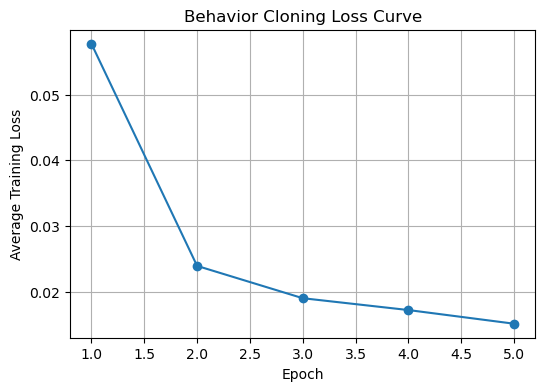

In [15]:
losses = []
for epoch in range(5):
    avg_loss = train_one_epoch(loader, policy, optimizer, loss_fn)
    losses.append(avg_loss)
    print(f"Epoch {epoch+1}/5 — Avg Loss: {avg_loss:.6f} \n")

# plot the loss curve from initial training (behavior cloning)
plt.figure(figsize=(6,4))
plt.plot(range(1, len(losses)+1), losses, marker='o')
plt.xlabel('Epoch')
plt.ylabel('Average Training Loss')
plt.title('Behavior Cloning Loss Curve')
plt.grid(True)
plt.show()

## DAgger Iterations

In [16]:
import numpy as np
import torch
from torch.utils.data import TensorDataset, DataLoader
import matplotlib.pyplot as plt

# === DAgger Iterations using DataLoader ===

# Parameters
dagger_iterations       = 5
episodes_per_iteration  = 1
train_epochs_per_iter   = 10
batch_size              = 64

# Start from initial BC dataset
states_np  = initial_expert_states_np.copy()   # (N0, 21)
actions_np = initial_expert_actions_np.copy()  # (N0,)

for it in range(dagger_iterations):
    new_states = []
    new_actions = []

    # 1. Collect new data by rolling out current policy
    for ep in range(episodes_per_iteration):
        start = time.time()
        state = env.reset()
        for step in range(max_steps):
            # Student policy action
            state_tensor = torch.from_numpy(state).float().unsqueeze(0)
            action_pred  = policy(state_tensor).item()

            # Record state & expert correction
            new_states.append(state)
            expert_act = expert.select_action(state, env, step)
            new_actions.append(expert_act)

            # Step environment with student action
            state, _, done, info = env.step(action_pred)
            if done:
                print(f"\nEpisode terminated: {info}")
                break
        end = time.time()
        print(f"Episode {ep+1}/{episodes_per_iteration} in DAgger Iteration {it+1}/{dagger_iterations} is done. \n Time: {end-start:.2f} seconds")
    

    # 2. Append new data to the NumPy arrays
    new_states_np  = np.array(new_states, dtype=np.float32)
    new_actions_np = np.array(new_actions, dtype=np.float32)
    states_np  = np.concatenate([states_np,  new_states_np], axis=0)
    actions_np = np.concatenate([actions_np, new_actions_np], axis=0)

    # 3. Rebuild dataset & loader
    states_tensor  = torch.from_numpy(states_np).float()
    actions_tensor = torch.from_numpy(actions_np).float()
    dataset = TensorDataset(states_tensor, actions_tensor)
    loader  = DataLoader(dataset, batch_size=batch_size, shuffle=True)

    # 4. Train on the aggregated dataset
    print(f"\n--- DAgger Iteration {it+1}/{dagger_iterations} Training ---")
    iter_losses = []
    for epoch in range(train_epochs_per_iter):
        avg_loss = train_one_epoch(loader, policy, optimizer, loss_fn)
        iter_losses.append(avg_loss)
        print(f" Iter {it+1} Epoch {epoch+1}/{train_epochs_per_iter} — Avg Loss: {avg_loss:.6f}")

    # Optional: plot loss curve for this iteration
    # plt.figure(figsize=(5,3))
    # plt.plot(range(1, len(iter_losses)+1), iter_losses, marker='o')
    # plt.title(f'Iter {it+1} BC Loss Curve')
    # plt.xlabel('Epoch')
    # plt.ylabel('Avg MSE Loss')
    # plt.grid(True)
    # plt.show()

    # 5. Evaluate policy
    avg_reward = evaluate_policy(env, policy, max_steps=max_steps, policy_name=f'DAgger_{it+1}')
    print(f" After DAgger Iter {it+1}, Avg Reward = {avg_reward:.2f}")


Episode terminated: Time limit reached
Episode 1/1 in DAgger Iteration 1/5 is done. 
 Time: 151.49 seconds

--- DAgger Iteration 1/5 Training ---
→ policy is in training mode
 Iter 1 Epoch 1/10 — Avg Loss: 0.010523
→ policy is in training mode
 Iter 1 Epoch 2/10 — Avg Loss: 0.009096
→ policy is in training mode
 Iter 1 Epoch 3/10 — Avg Loss: 0.008469
→ policy is in training mode
 Iter 1 Epoch 4/10 — Avg Loss: 0.008042
→ policy is in training mode
 Iter 1 Epoch 5/10 — Avg Loss: 0.008145
→ policy is in training mode
 Iter 1 Epoch 6/10 — Avg Loss: 0.007942
→ policy is in training mode
 Iter 1 Epoch 7/10 — Avg Loss: 0.008184
→ policy is in training mode
 Iter 1 Epoch 8/10 — Avg Loss: 0.007764
→ policy is in training mode
 Iter 1 Epoch 9/10 — Avg Loss: 0.007446
→ policy is in training mode
 Iter 1 Epoch 10/10 — Avg Loss: 0.007660
→ policy is in evaluation mode

Episode terminated: Time limit reached
Total reward obtained from current policy: -1191.95
 After DAgger Iter 1, Avg Reward = -119